## refer to: https://www.kaggle.com/raddar/paris-madness

# import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
import datetime
import copy
import mlflow
from sklearn import preprocessing
import lightgbm as lgb
import seaborn as sns

pd.set_option("display.max_column", 999)
# print(os.listdir("../input"))

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# setting mlflow

In [2]:
# class Mlflow_Config:
    
#     def __init__(self, uri='../mlflow/mlruns/'):
#         mlflow.set_tracking_uri(uri)
#         self.tracking = mlflow.tracking.MlflowClient()
#         print('experiment_name:', *[i.name for i in self.tracking.list_experiments()], sep='\n\t')
    
#     @staticmethod
#     def set_experiment(experiment_name):
#         # こういうのって必要？明示的に書いておいたけど。。。
#         mlflow.set_experiment(experiment_name)

# trial = Mlflow_Config()
# trial.set_experiment('booster')

In [3]:
# tracking = mlflow.tracking.MlflowClient()
# print('experiment_name:', *[i.name for i in tracking.list_experiments()], sep='\n\t')

In [4]:
# tags = {
#     'random_seed': 'ON',
#     'repeat_cv': '3'
# }

# mlflow_config = {
#     'uri': '../mlflow/mlruns/',
#     'experiment_name': 'repeat_cv',
#     'tags': tags,
#     'run_id': None
# }
# mlflow.set_tracking_uri(mlflow_config['uri'])
# mlflow.set_experiment(mlflow_config['experiment_name'])
# mlflow_config['tracking'] = mlflow.tracking.MlflowClient()
# mlflow_config['experiment_id'] = mlflow_config['tracking'].get_experiment_by_name(mlflow_config['experiment_name']).experiment_id
# print(mlflow_config)

# Load the data!

In [2]:
path = '../W/input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/'
submit_csv_path = '../W/input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament'
output_path = '../output/W/'

tourney_results = pd.read_csv(os.path.join(path, 'WNCAATourneyDetailedResults.csv'))
seeds = pd.read_csv(os.path.join(path, 'WNCAATourneySeeds.csv'))
regular_results = pd.read_csv(os.path.join(path, 'WRegularSeasonDetailedResults.csv'))
conferences = pd.read_csv(os.path.join(path, 'WTeamConferences.csv'))

In [12]:
sub = pd.read_csv(os.path.join(submit_csv_path, 'WSampleSubmissionStage1_2020.csv'))

def transform_test(test):
    # sub["Season"] = 2018 # なぜ2018年固定？
    test['Season'] = test['ID'].apply(lambda x: x[0:4]).astype(int)
    test["T1_TeamID"] = test["ID"].apply(lambda x: x[5:9]).astype(int)
    test["T2_TeamID"] = test["ID"].apply(lambda x: x[10:14]).astype(int)
    return test
sub = transform_test(sub)
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2015_3106_3107,0.5,2015,3106,3107
1,2015_3106_3110,0.5,2015,3106,3110
2,2015_3106_3113,0.5,2015,3106,3113
3,2015_3106_3114,0.5,2015,3106,3114
4,2015_3106_3116,0.5,2015,3106,3116


# Data preparing!

In [7]:
class Preprocessor_NCAA:
    SWAP_COLS = ['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
                                'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
                                'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']

    STATS_EXC_COLS = ['DayNum', 'NumOT', 'T2_TeamID', 'location']
    
    def __init__(self, regular_results, tourney_results, seeds, conferences, train_flag=True):
        self.regular_data = regular_results
        self.tourney_data = tourney_results
        self.ranking_data = self.meke_rangking_data() # rankingので０たは2013以降しかないから注意が必要？
        self.seeds = seeds
        self.conferences = self.encode_conferences_data(conferences)
        self.train_flag = train_flag
    
    def meke_rangking_data(self):
        result_df = tourney_results[tourney_results.DayNum>=132].sort_values(['Season', 'DayNum'], ascending=False)
        result_df['place'] = result_df.groupby('Season')['DayNum'].rank(ascending=False, method="first")
        result_df.place = result_df.place.astype(int)

        winner_df = result_df[result_df.place==1][['Season', 'WTeamID', 'place']]
        winner_df.columns.values[1] = 'TeamID'
        loser_df = result_df[result_df.place<=63][['Season', 'LTeamID', 'place']]
        loser_df.columns.values[1] = 'TeamID'
        
        # best2, 4, 8, 16, 32のリストをSeason分作成
        place_list = []

        for _ in result_df['Season'].unique():
            place_list.extend([2**i for i in range(1, 7) for _ in range(2**(i-1))])
        loser_df['place'] = place_list
        return pd.concat([winner_df, loser_df], axis=0).sort_values(['Season', 'place']).reset_index(drop=True)
    
    def fit(self):
        swap_regular_data = self.swap_data(self.regular_data)
        encoded_regular_df = self.encode_detail_data(swap_regular_data)
        self.regular_data = self.feature_eng_data(encoded_regular_df)
        
        if self.train_flag:
            self.tourney_data = self.swap_data(self.tourney_data)[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

        self.cols =  list(set(self.regular_data.columns) - set(self.STATS_EXC_COLS))
        location_df_list = self.get_data_byLocation(self.regular_data)
        last14days_stats = self.get_lastNdays_data(self.regular_data, 14) # 14日前までのデータ同様、ホームだけ、アウェーだけ、ニュートラルだけのデータ作ってjoin_mean
        
        train_df = self.join_MeanValue(self.regular_data[self.cols], self.tourney_data)
        
        location_df_list.append(last14days_stats) # 絶対もっと綺麗にかける
        for df in location_df_list:
            train_df = self.join_MeanValue(df, train_df)
        train_df = self.join_GLM(train_df)
        train_df = self.join_seed(train_df)
        train_df = self.join_ranking(train_df)
        
        return train_df
    
    def swap_data(self, df):
        copy_df = df.copy()
        dfswap = copy_df[self.SWAP_COLS]
        dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
        dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
#         copy_df.columns.values[6] = 'locationXX'
#         dfswap.columns.values[6] = 'locationXX'    

        copy_df.columns = [x.replace('W','T1_').replace('L','T2_') if x!='WLoc' else 'location' for x in list(copy_df.columns)]
        dfswap.columns = [x.replace('L','T1_').replace('W','T2_') if x!='WLoc' else 'location' for x in list(dfswap.columns)]

        return pd.concat([copy_df, dfswap]).reset_index(drop=True)

    def encode_detail_data(self, df):
        df.loc[df.location=='N','location'] = '0'
        df.loc[df.location=='H','location'] = '1'
        df.loc[df.location=='A','location'] = '-1'
        df.location = df.location.astype(int)
        
        return df
    
    def encode_conferences_data(self, conferences):
        le = preprocessing.LabelEncoder()
        le.fit(conferences['ConfAbbrev'])
        conferences['ConfAbbrev'] = le.transform(conferences['ConfAbbrev'])
        return conferences
    
    def feature_eng_data(self, df):
        df['PointDiff'] = df['T1_Score'] - df['T2_Score']
        # 追加
        df['T1_win'] = np.where(df['PointDiff']>0, 1, 0) # 勝ち負け
        df['T2_win'] = np.where(df['PointDiff']>0, 0, 1)
        for t in ['T1', 'T2']:
            df[f'{t}_FGmissed'] = df[f'{t}_FGA'] - df[f'{t}_FGM'] # シュートミス
            df[f'{t}_FGmissed3'] = df[f'{t}_FGA3'] - df[f'{t}_FGM3'] # シュートミス
            df[f'{t}_FTmissed'] = df[f'{t}_FTA'] - df[f'{t}_FTM'] # フリースローミス
            
            df[f'{t}_FGsuccess_ratio'] = df[f'{t}_FGM'] / df[f'{t}_FGA'] # シュート成功率
            df[f'{t}_FG3success_ratio'] = df[f'{t}_FGM3'] / df[f'{t}_FGA3'] # 3Pシュート成功率
            df[f'{t}_FTsuccess_ratio'] = df[f'{t}_FTM'] / df[f'{t}_FTA'] # フリースロー成功率
            
            df[f'{t}_FG2ratio'] = df[f'{t}_FGM'] / df[f'{t}_Score'] # 2点シュートの割合
            df[f'{t}_FG3ratio'] = df[f'{t}_FGM3'] / df[f'{t}_Score'] # 3Pシュートの割合
            df[f'{t}_FGratio'] = df[f'{t}_FGM'] + df[f'{t}_FGM3'] / df[f'{t}_Score'] # FGの割合
            df[f'{t}_FTratio'] = df[f'{t}_FTM'] / df[f'{t}_Score'] # フリースローの割合
            
            df[f'{t}_Rratio'] = df[f'{t}_DR'] / df['T1_OR'] + df['T1_DR'] + df['T2_OR'] + df['T2_DR'] # リバウンド率
            df[f'{t}_ORratio'] = df[f'{t}_OR'] / df[f'{t}_OR'] + df[f'{t}_DR']
            df[f'{t}_DRratio'] = df[f'{t}_DR'] / df[f'{t}_OR'] + df[f'{t}_DR']
            
            df[f'{t}_ASTratio'] = df[f'{t}_Ast'] / df[f'{t}_FGM'] # アシスト率
            df[f'{t}_PF_byPeriod'] = df[f'{t}_PF'] / 4 # ピリオドごとの平均、PFってこんなに多いの！？
            df['T1_over5PF'] = np.where(df[f'{t}_PF_byPeriod']>=5, 1, 0) # 平均が5ファウル超えているか(チームファウル)

        df['T1_ORratio_op']  = df['T1_OR'] / df['T1_OR'] + df['T2_DR'] # 攻撃時のリバウンド、守備時のリバウンド(リストをスライスする形ならfor文に組み込めた)
        df['T1_DRratio_op']  = df['T1_DR'] / df['T1_DR'] + df['T2_OR']
        df['T2_ORratio_op']  = df['T2_OR'] / df['T1_DR'] + df['T2_OR']
        df['T2_DRratio_op']  = df['T2_DR'] / df['T1_OR'] + df['T2_DR']

        df['T1_FGblock'] = df['T1_Blk'] / df['T2_FGmissed'] # ブロック率
        df['T2_FGblock'] = df['T2_Blk'] / df['T1_FGmissed']
        df['T1_FGAblock'] = df['T1_Blk'] / df['T2_FGA'] # ブロック率２ どっちがいいかわからないから両方作った 
        df['T2_FGAblock'] = df['T2_Blk'] / df['T1_FGA']
        
        return df

    def join_MeanValue(self, df, toJoin_df):
        season_statistics = self.get_mean_value(df)
        season_statistics_T1 = season_statistics.copy()
        season_statistics_T2 = season_statistics.copy()

        season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") if not x == 'Season' else x for x in list(season_statistics_T1.columns)]
        season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") if not x == 'Season' else x for x in list(season_statistics_T2.columns)]
        
        toJoin_df = pd.merge(toJoin_df, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        toJoin_df = pd.merge(toJoin_df, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
        
        return toJoin_df

    def get_mean_value(self, df):
        keys = ["Season", 'T1_TeamID']
        funcs = [np.mean]
        
        season_statistics = df.groupby(keys).agg(funcs).reset_index()
        season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
        
        return season_statistics
    
    def get_data_byLocation(self, df):
        home_df = df.loc[df.location ==1].reset_index(drop=True)[self.cols]
        home_df = self.column_addNamed(home_df, '_location{}'.format('1'))
        
        not_home_df = df.loc[df.location !=1].reset_index(drop=True)[self.cols]
        not_home_df = self.column_addNamed(not_home_df, '_location{}'.format('_not1'))
        return [home_df, not_home_df]
            
    
    def get_lastNdays_data(self, df, n):
        # 追加：ここはwinかどうか以外も足していい気がする
        lastNdays_stats = df.loc[df.DayNum>=(132-n)].reset_index(drop=True)[self.cols] # Regular: 0~132
        lastNdays_stats = self.column_addNamed(lastNdays_stats, '_last{}days'.format(n))
        return lastNdays_stats
    
    def column_addNamed(self, df, addName):
        not_add_cols = ['T1_TeamID', 'Season']
        df.columns = [col + addName if  col not in tuple(not_add_cols) else col for col in df.columns]
        return df
    
    def join_GLM(self, toJoin_df):
        glm_quality = self.fit_predict_GLM()
        glm_quality_T1 = glm_quality.copy()
        glm_quality_T2 = glm_quality.copy()
        glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
        glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']
        
        toJoin_df = pd.merge(toJoin_df, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        toJoin_df = pd.merge(toJoin_df, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
        
        return toJoin_df
        
    def fit_predict_GLM(self):
        self.make_GLMtrain()
        glm_quality = pd.concat([self.team_quality(season) for season in  range(2010, 2020)]).reset_index(drop=True)
        return glm_quality
    
    def make_GLMtrain(self):
        regular_season_effects = self.regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff', 'T1_win']].copy()
        regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
        regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
        march_madness = pd.merge(self.seeds[['Season','TeamID']],self.seeds[['Season','TeamID']],on='Season')
        march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
        march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
        march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
        # シーズンごとのシード内の組み合わせ全てを作成、レギュラーシーズン中に行われなかった試合についてはteam_qualityがnullになる（joinで外れる）
        regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
        self.regular_season_effects = regular_season_effects
    
    def team_quality(self, season):
        formula = 'T1_win~T1_TeamID+T2_TeamID-1'
        glm = sm.GLM.from_formula(formula=formula, 
                                  data=self.regular_season_effects.loc[self.regular_season_effects.Season==season,:], 
                                  family=sm.families.Binomial()).fit()

        quality = pd.DataFrame(glm.params).reset_index()
        quality.columns = ['TeamID','quality']
        quality['Season'] = season
        quality['quality'] = np.exp(quality['quality'])
        quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
        quality['TeamID'] = quality['TeamID'].apply(lambda x: x[-5:-1]).astype(int)
        return quality
    
    def join_seed(self, toJoin_df):
        seeds['seed'] = self.seeds['Seed'].apply(lambda x: int(x[1:3]))
        seeds_T1 = seeds[['Season','TeamID','seed']].copy()
        seeds_T2 = seeds[['Season','TeamID','seed']].copy()
        seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
        seeds_T2.columns = ['Season','T2_TeamID','T2_seed']
        toJoin_df = pd.merge(toJoin_df, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        toJoin_df = pd.merge(toJoin_df, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
        toJoin_df["Seed_diff"] = toJoin_df["T1_seed"] - toJoin_df["T2_seed"]
        
        return toJoin_df

    def join_ranking(self, toJoin_df):
        sum_3y_df = self.pre_3yaer_result(self.ranking_data)
        sum_3y_df = self.groupby_conference_data(sum_3y_df)
        sum_3y_df_T1 = sum_3y_df.copy()
        sum_3y_df_T2 = sum_3y_df.copy()
        sum_3y_df_T1.columns = ["T1_" +  x if not x == 'Season' else x for x in list(sum_3y_df_T1.columns)]
        sum_3y_df_T2.columns = ["T2_" +  x if not x == 'Season' else x for x in list(sum_3y_df_T2.columns)]
        
        toJoin_df = pd.merge(toJoin_df, sum_3y_df_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        toJoin_df = pd.merge(toJoin_df, sum_3y_df_T2, on = ['Season', 'T2_TeamID'], how = 'left')
        toJoin_df = toJoin_df.fillna(0)
        toJoin_df['ranking_count_diff'] = toJoin_df['T1_count'] - toJoin_df['T2_count']
        
        return toJoin_df

    def pre_3yaer_result(self, ranking_df):
    # 直近3年の成績(2013~2020)
        sum_3y_df = pd.DataFrame(columns=['TeamID', 'place_1', 'place_2', 'place_4', 'place_8', 'place_16', 'place_32', 'place_64', 'Season'])

        for i in range(2013, 2021):
            tmp = ranking_df.loc[(ranking_df.Season==i-1) | (ranking_df.Season == i-2) | (ranking_df.Season == i-3)]
            tmp = tmp.groupby(['TeamID', 'place']).count().reset_index(drop=False)
            tmp = pd.pivot(tmp, index='TeamID', columns='place', values='Season').reset_index().fillna(0)
            tmp.columns = ['TeamID', 'place_1', 'place_2', 'place_4', 'place_8', 'place_16', 'place_32', 'place_64']
            tmp['Season'] = i
            sum_3y_df = pd.concat([sum_3y_df, tmp], axis=0)
        sum_3y_df['count'] = sum_3y_df['place_1'] + sum_3y_df['place_2'] + sum_3y_df['place_4'] + sum_3y_df['place_8'] + sum_3y_df['place_16'] + sum_3y_df['place_32'] + sum_3y_df['place_64']
        return sum_3y_df
    
    def groupby_conference_data(self, df):
        funcs = [np.mean, np.sum]
        base = pd.merge(df, self.conferences, on = ['Season', 'TeamID'], how='left')
        tmp = base.drop('TeamID', axis=1).fillna(0).groupby(['Season', 'ConfAbbrev']).agg(funcs).reset_index()
        tmp.columns = [''.join(col).strip() for col in tmp.columns.values]
        return pd.merge(base, tmp, on = ['Season', 'ConfAbbrev'], how='left').fillna(0) # .drop('ConfAbbrev', axis=1) カテゴリ値も含める？

In [8]:
preprocessor = Preprocessor_NCAA(regular_results, tourney_results, seeds, conferences, True)
tourney_data = preprocessor.fit()

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:167: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: divide by

In [9]:
tourney_data.shape

(1260, 622)

In [10]:
features = [col for col in tourney_data.columns if col not in ('DayNum', 'Season', 'T1_Score', 'T1_TeamID', 'T2_Score', 'T2_TeamID') ]
print(len(features))

616


In [11]:
sub_preprocessor = Preprocessor_NCAA(regular_results,sub, seeds, conferences, False)
sub = sub_preprocessor.fit()
sub.head()

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:167: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: divide by

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Stlmean,T1_opponent_Stlmean,T1_ORmean,T1_FGA3mean,T1_opponent_FGmissed3mean,T1_ASTratiomean,T1_Rratiomean,T1_opponent_Astmean,T1_FGmissedmean,T1_opponent_FGsuccess_ratiomean,T1_opponent_PFmean,T1_FTMmean,T1_opponent_FTsuccess_ratiomean,T1_opponent_TOmean,T1_opponent_FG3ratiomean,T1_opponent_FTMmean,T1_FGratiomean,T1_FG3success_ratiomean,T1_opponent_FGAmean,T1_ORratiomean,T1_opponent_Scoremean,T1_Blkmean,T1_FGmissed3mean,T1_FTratiomean,T1_FGM3mean,T1_opponent_Blkmean,T1_opponent_FTratiomean,T1_PFmean,T1_FGAblockmean,T1_opponent_FTAmean,T1_PointDiffmean,T1_opponent_PF_byPeriodmean,T1_opponent_ORmean,T1_Astmean,T1_FTsuccess_ratiomean,T1_FG3ratiomean,T1_FGMmean,T1_FGsuccess_ratiomean,T1_opponent_ORratio_opmean,T1_opponent_FGA3mean,T1_opponent_FGM3mean,T1_winmean,T1_DRratiomean,T1_opponent_Rratiomean,T1_DRratio_opmean,T1_Scoremean,T1_opponent_FG3success_ratiomean,T1_opponent_DRmean,T1_FTAmean,T1_opponent_ASTratiomean,T1_opponent_FGratiomean,T1_TOmean,T1_opponent_FTmissedmean,T1_over5PFmean,T1_opponent_DRratio_opmean,T1_opponent_FGblockmean,T1_FG2ratiomean,T1_opponent_ORratiomean,T1_opponent_winmean,T1_PF_byPeriodmean,T1_FGblockmean,T1_FTmissedmean,T1_ORratio_opmean,T1_opponent_FGmissedmean,T1_DRmean,T1_opponent_FGAblockmean,T1_opponent_DRratiomean,T1_opponent_FG2ratiomean,T1_FGAmean,T1_opponent_FGMmean,T2_Stlmean,T2_opponent_Stlmean,T2_ORmean,T2_FGA3mean,T2_opponent_FGmissed3mean,T2_ASTratiomean,T2_Rratiomean,T2_opponent_Astmean,T2_FGmissedmean,T2_opponent_FGsuccess_ratiomean,T2_opponent_PFmean,T2_FTMmean,T2_opponent_FTsuccess_ratiomean,T2_opponent_TOmean,T2_opponent_FG3ratiomean,T2_opponent_FTMmean,T2_FGratiomean,T2_FG3success_ratiomean,T2_opponent_FGAmean,T2_ORratiomean,T2_opponent_Scoremean,T2_Blkmean,T2_FGmissed3mean,T2_FTratiomean,T2_FGM3mean,T2_opponent_Blkmean,T2_opponent_FTratiomean,T2_PFmean,T2_FGAblockmean,T2_opponent_FTAmean,T2_PointDiffmean,T2_opponent_PF_byPeriodmean,T2_opponent_ORmean,T2_Astmean,T2_FTsuccess_ratiomean,T2_FG3ratiomean,T2_FGMmean,T2_FGsuccess_ratiomean,T2_opponent_ORratio_opmean,T2_opponent_FGA3mean,T2_opponent_FGM3mean,T2_winmean,T2_DRratiomean,T2_opponent_Rratiomean,T2_DRratio_opmean,T2_Scoremean,T2_opponent_FG3success_ratiomean,T2_opponent_DRmean,T2_FTAmean,T2_opponent_ASTratiomean,T2_opponent_FGratiomean,T2_TOmean,T2_opponent_FTmissedmean,T2_over5PFmean,T2_opponent_DRratio_opmean,T2_opponent_FGblockmean,T2_FG2ratiomean,T2_opponent_ORratiomean,T2_opponent_winmean,T2_PF_byPeriodmean,T2_FGblockmean,T2_FTmissedmean,T2_ORratio_opmean,T2_opponent_FGmissedmean,T2_DRmean,T2_opponent_FGAblockmean,T2_opponent_DRratiomean,T2_opponent_FG2ratiomean,T2_FGAmean,T2_opponent_FGMmean,T1_Stl_location1mean,T1_opponent_Stl_location1mean,T1_OR_location1mean,T1_FGA3_location1mean,T1_opponent_FGmissed3_location1mean,T1_ASTratio_location1mean,T1_Rratio_location1mean,T1_opponent_Ast_location1mean,T1_FGmissed_location1mean,T1_opponent_FGsuccess_ratio_location1mean,T1_opponent_PF_location1mean,T1_FTM_location1mean,T1_opponent_FTsuccess_ratio_location1mean,T1_opponent_TO_location1mean,T1_opponent_FG3ratio_location1mean,T1_opponent_FTM_location1mean,T1_FGratio_location1mean,T1_FG3success_ratio_location1mean,T1_opponent_FGA_location1mean,T1_ORratio_location1mean,T1_opponent_Score_location1mean,T1_Blk_location1mean,T1_FGmissed3_location1mean,T1_FTratio_location1mean,T1_FGM3_location1mean,T1_opponent_Blk_location1mean,T1_opponent_FTratio_location1mean,T1_PF_location1mean,T1_FGAblock_location1mean,T1_opponent_FTA_location1mean,T1_PointDiff_location1mean,T1_opponent_PF_byPeriod_location1mean,T1_opponent_OR_location1mean,T1_Ast_location1mean,T1_FTsuccess_ratio_location1mean,T1_FG3ratio_location1mean,T1_FGM_location1mean,T1_FGsuccess_ratio_location1mean,T1_opponent_ORratio_op_location1mean,T1_opponent_FGA3_location1mean,T1_opponent_FGM3_location1mean,T1_win_location1mean,T1_DRratio_location1mean,T1_opponent_Rratio_location1mean,T1_DRratio_op_location1mean,T1_Score_location1mean,T1_opponent_FG3succ

In [12]:
eda_features = ['Seed_diff', 'T1_seed', 'T2_seed', 'T1_PointDiffmean', 'T2_PointDiffmean', 'T2_PointDiff_location_not1mean', 'T1_PointDiff_location_not1mean', 'T1_PointDiff_location1mean', 'T2_Astmean', 'T2_PointDiff_location1mean', 'T2_Ast_location1mean', 'T1_Astmean', 'T2_FGblock_location1mean', 'T1_FGblock_location1mean', 'T1_opponent_FG3success_ratio_last14daysmean', 'T1_FGratio_location_not1mean', 'T2_FGratio_location_not1mean', 'T1_FGsuccess_ratiomean', 'T1_Ast_location1mean', 'T2_opponent_FG3success_ratio_last14daysmean', 'T2_FGsuccess_ratiomean']

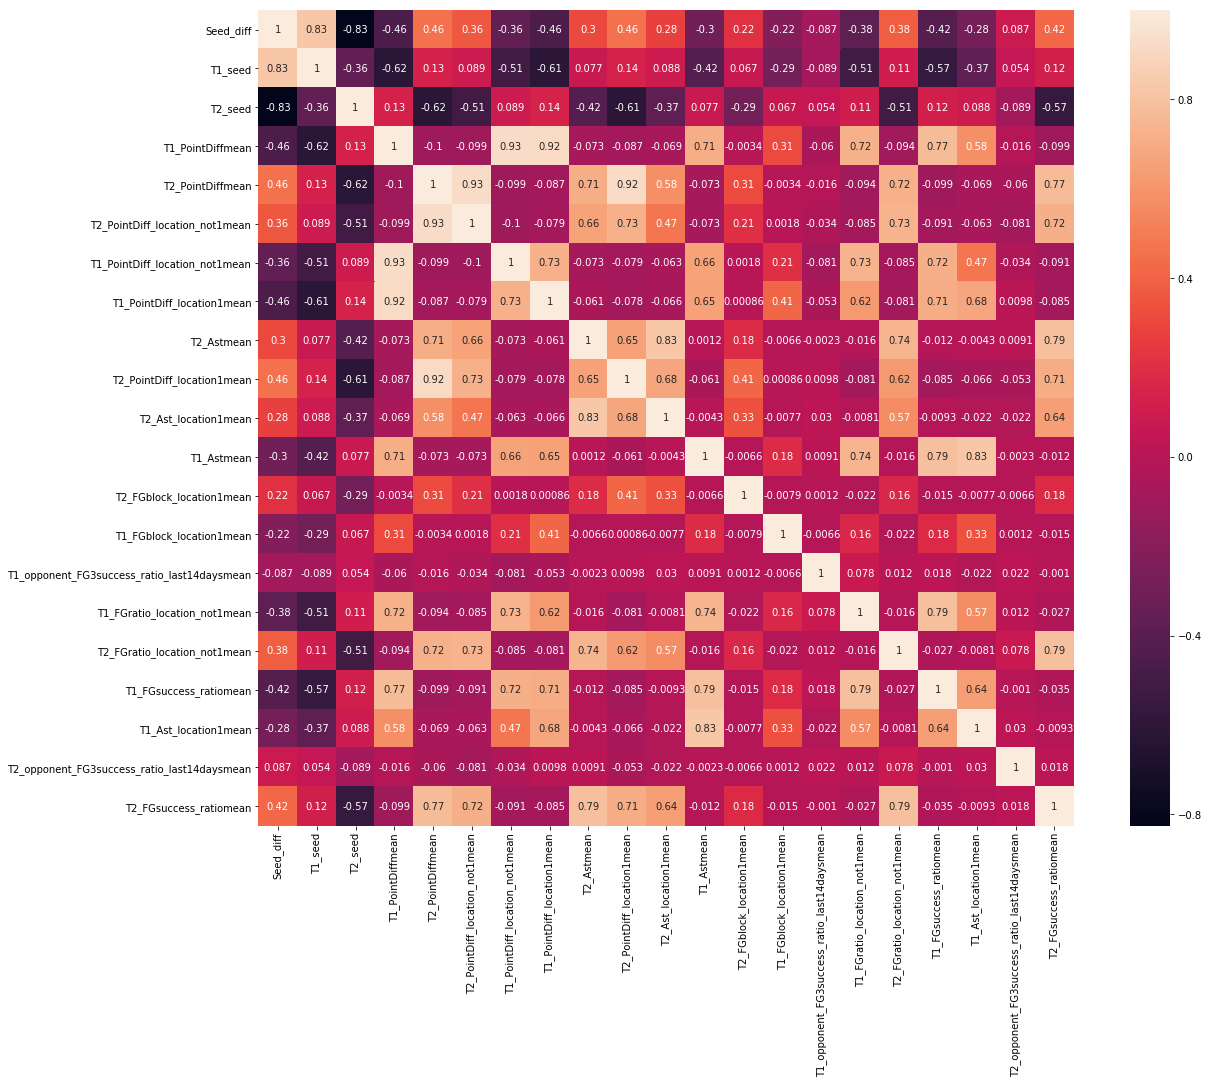

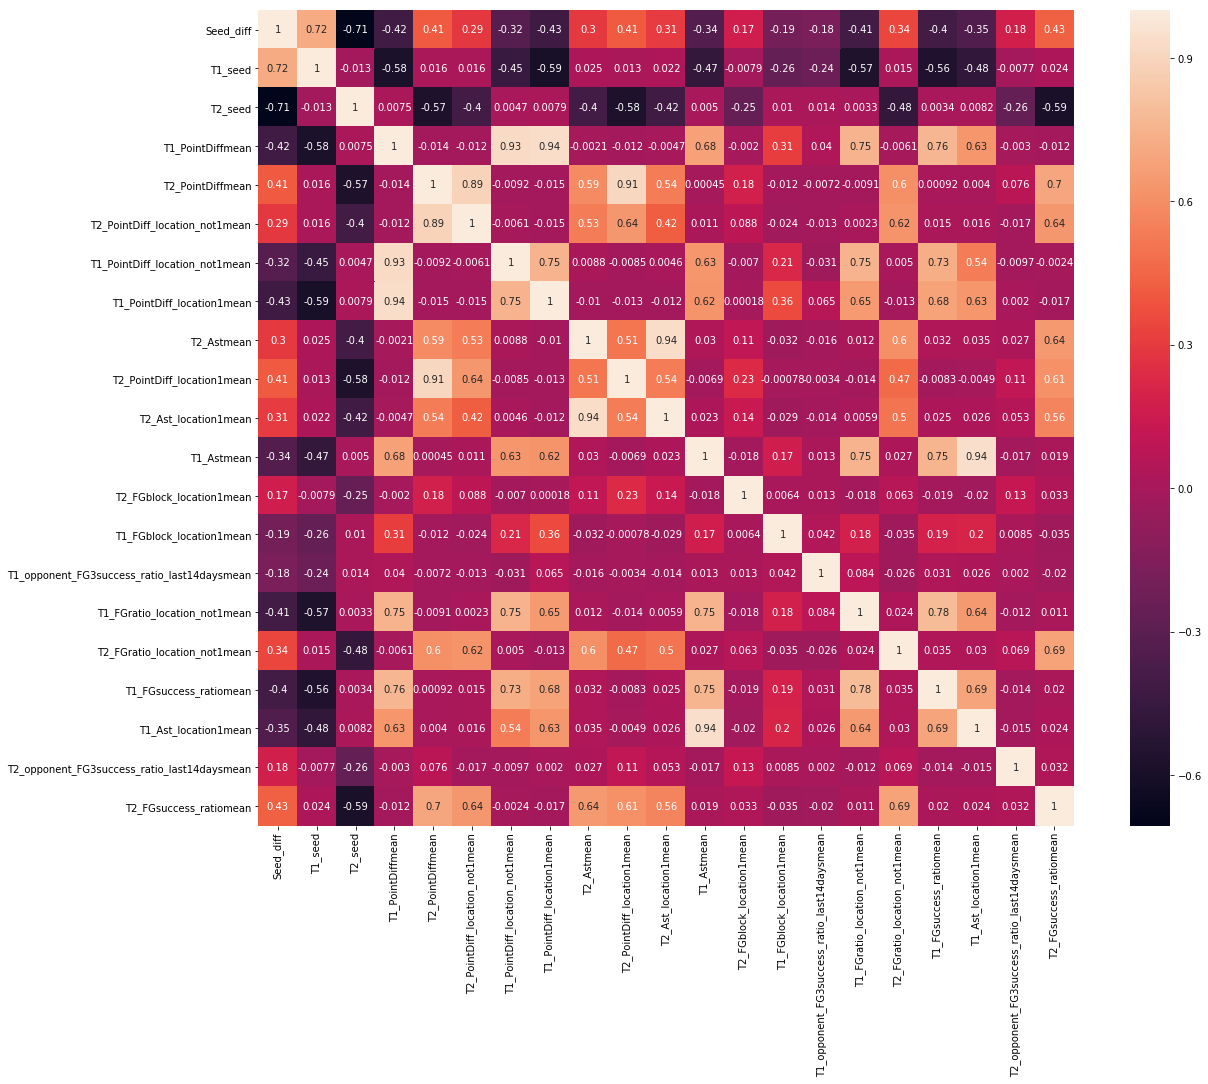

In [14]:
# seed_diffとの相関割と高くないか？
def wrapper_heatmap(df, features):
    plt.figure(figsize=(20,15))
    
    corr_df = df[features].corr()
    sns.heatmap(corr_df, square=True, annot=True)
    plt.show()
wrapper_heatmap(tourney_data, eda_features)
wrapper_heatmap(sub, eda_features)

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0


/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


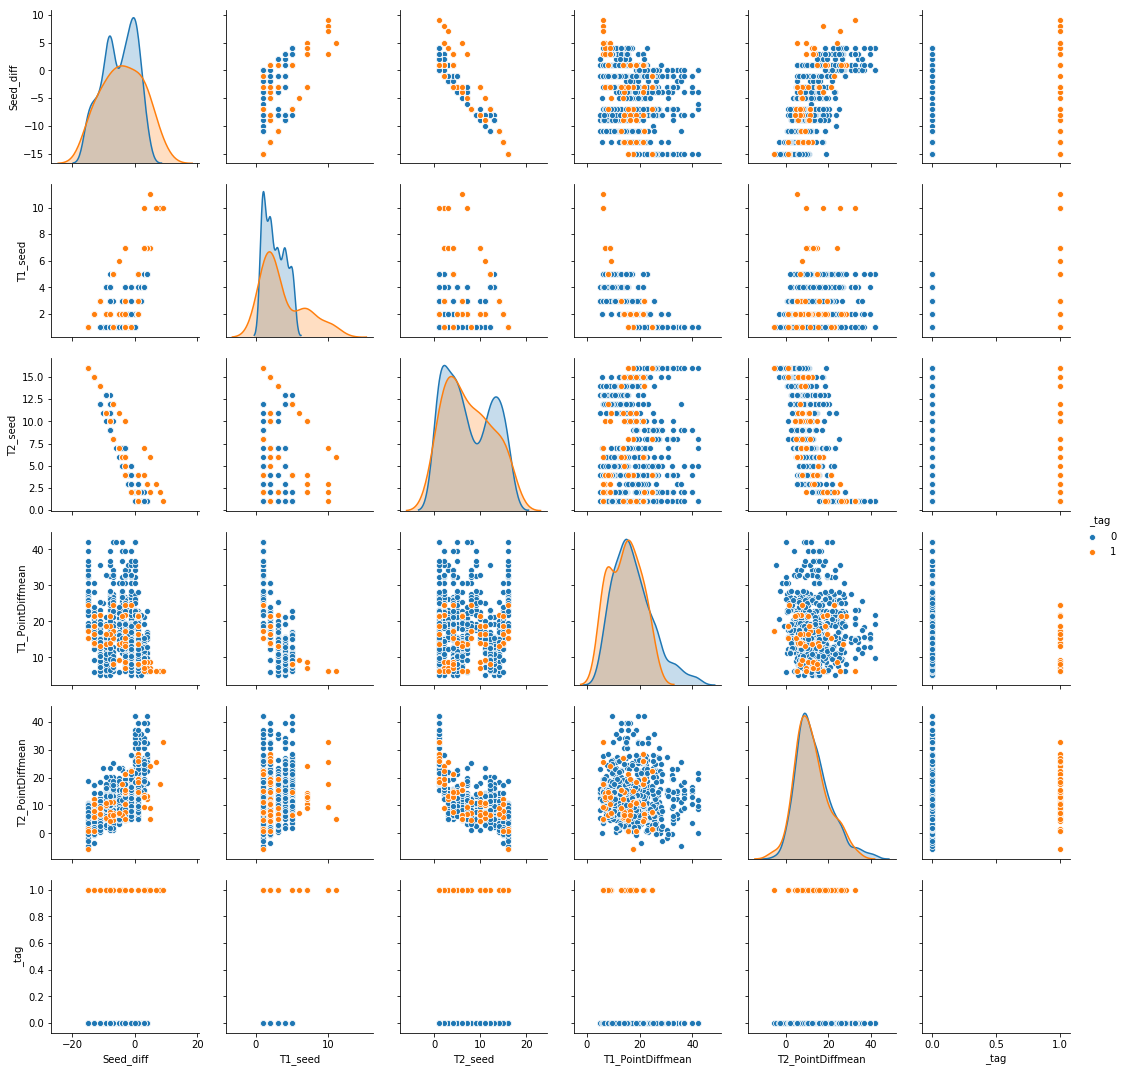

1


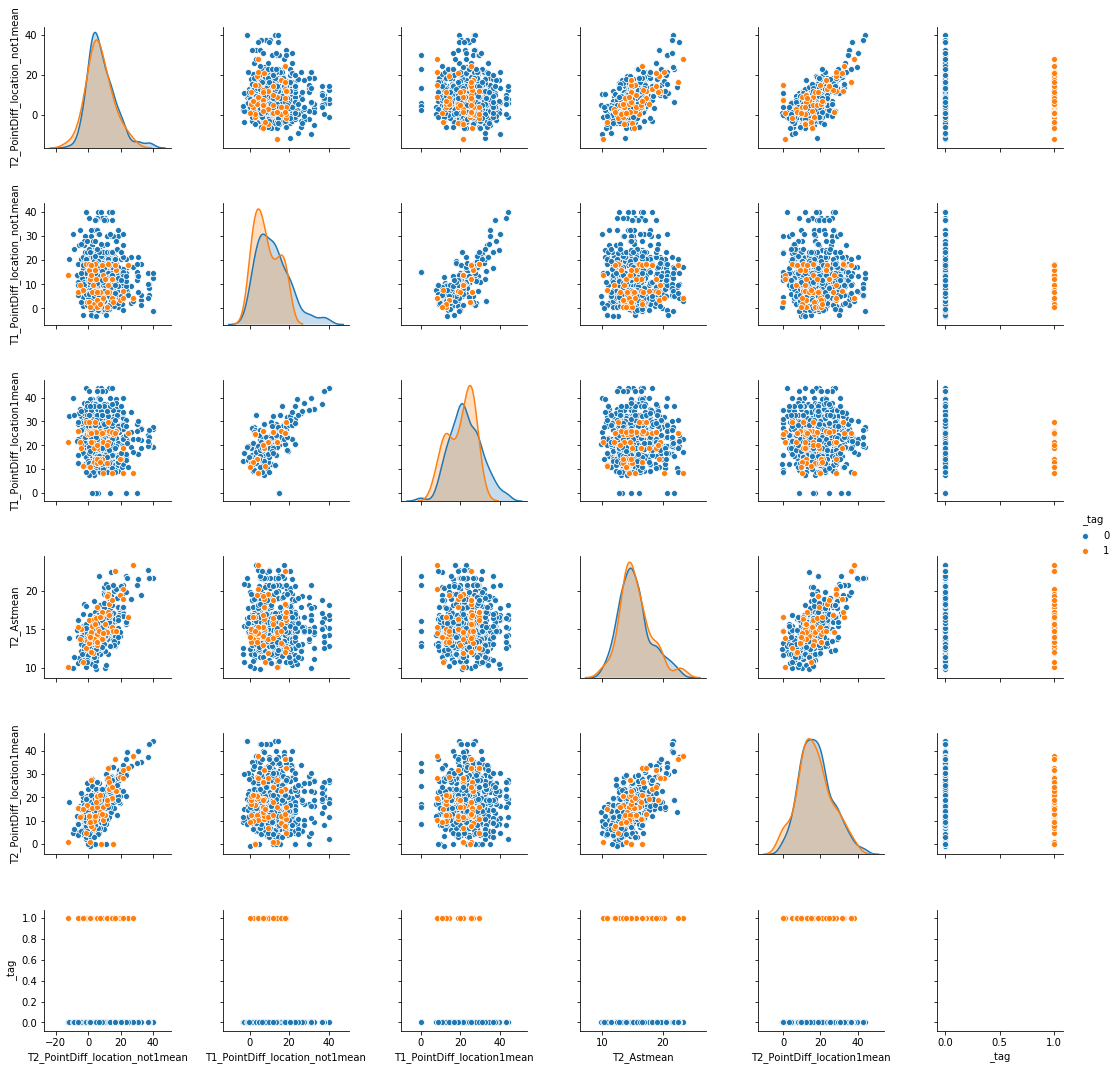

2


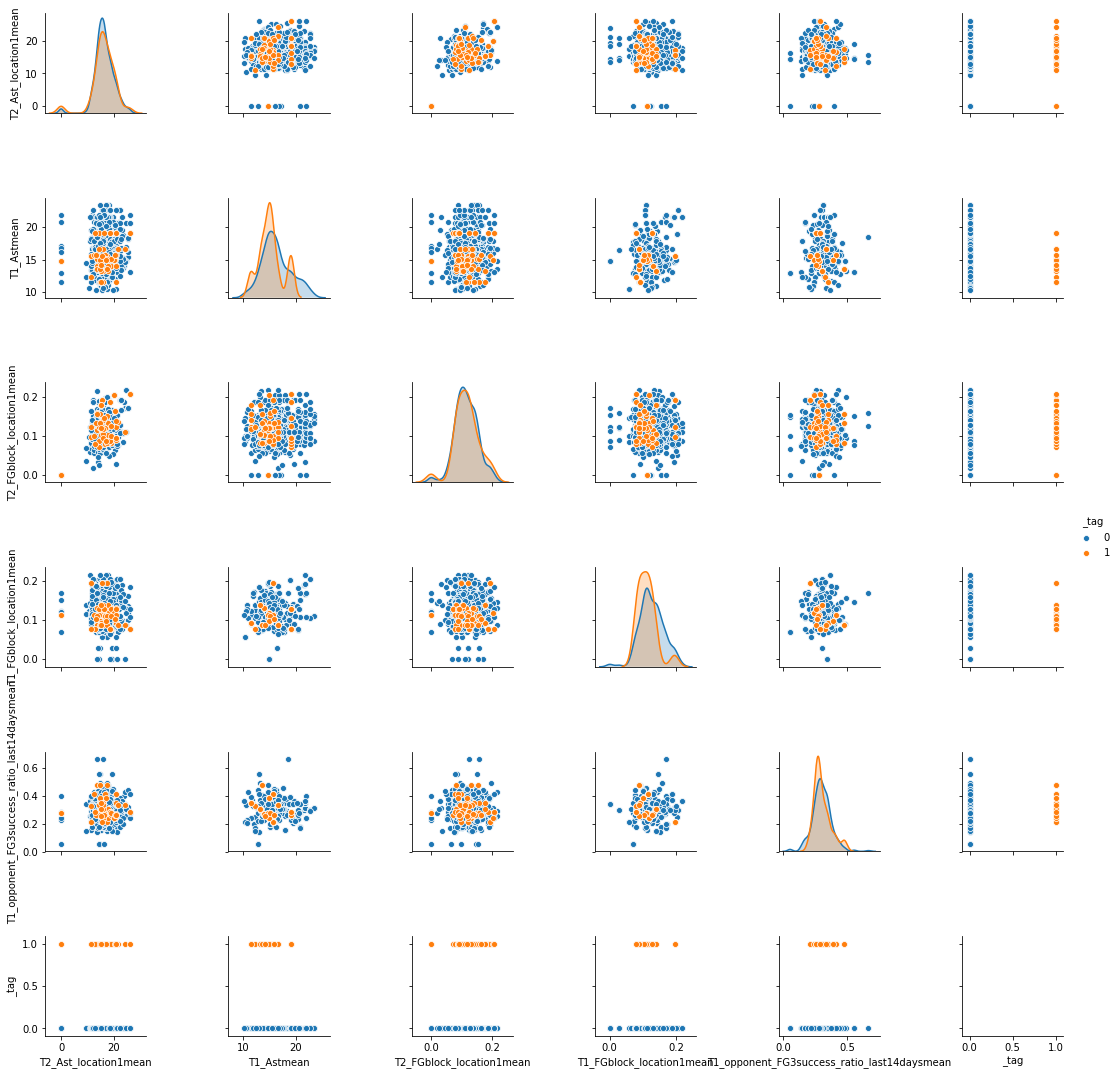

3


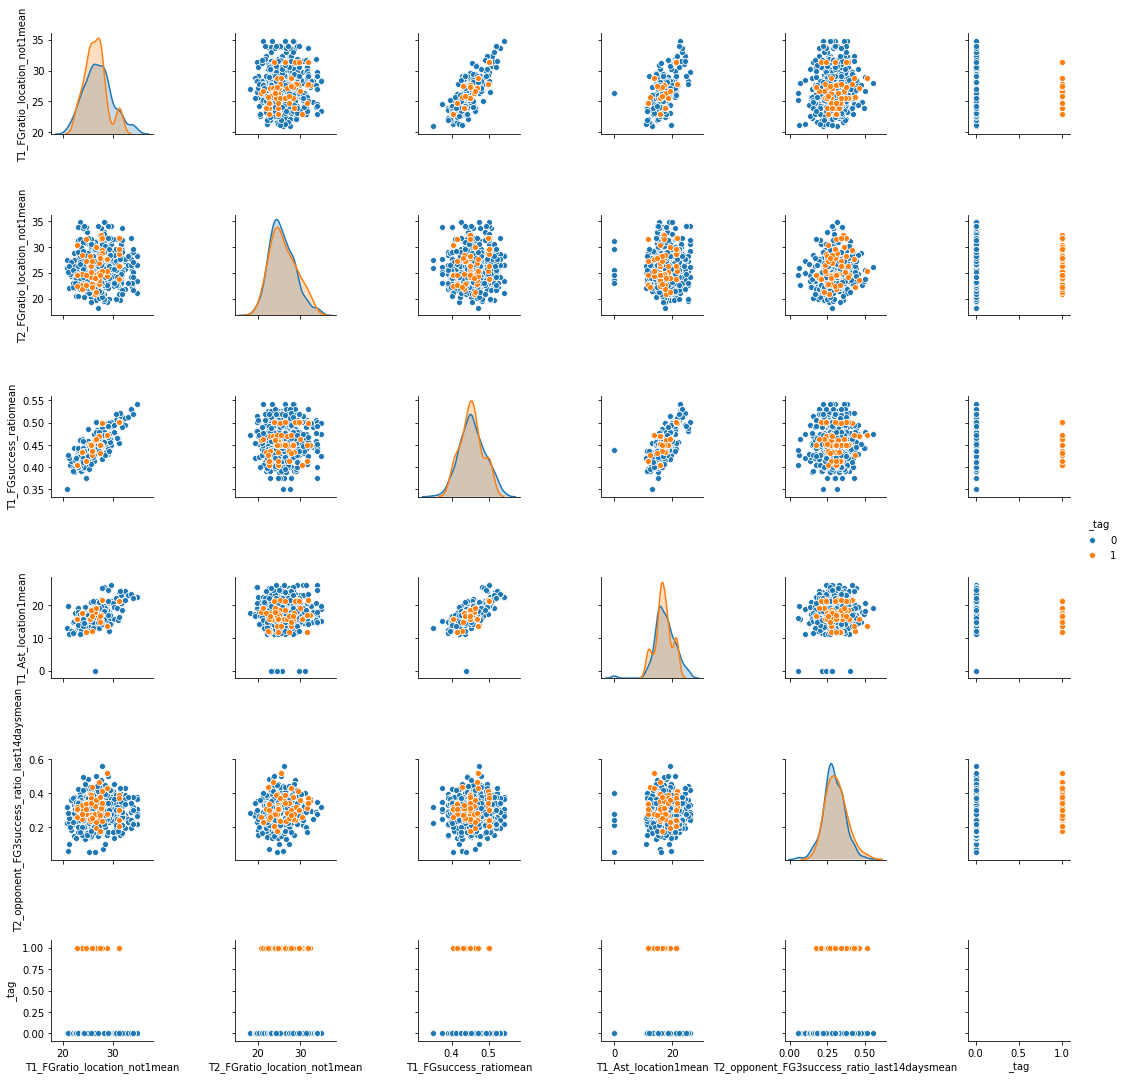

In [42]:
# 大番狂わせ？？
# 特に差異はないから予測できないなぁ...
target_df = tourney_data[(tourney_data.T1_TeamID == 3397) | (tourney_data.T1_TeamID== 3449) | (tourney_data.T1_TeamID== 3332)]
compare_df = tourney_data[tourney_data.T1_seed<=5]

def wrapper_pairplot(df1, df2, features):
    df1['_tag'] = 1
    df2['_tag'] = 0
    union_df = pd.concat([df1, df2])
    n = int(len(features)/5) # 5*5でplot
    
    for i in range(n):
        print(i)
        cols = features[i*5:(i+1)*5]
        cols.append('_tag')
        sns.pairplot(union_df[cols], hue="_tag")
        plt.show()
    
wrapper_pairplot(target_df, compare_df, eda_features)

In [47]:
target_df[['Season', 'T1_seed', 'T1_TeamID']].sort_values(['T1_TeamID', 'Season'])

,Season,T1_seed,T1_TeamID
465,2017,10,3332
484,2017,10,3332
495,2017,10,3332
1129,2017,10,3332
513,2018,2,3332
540,2018,2,3332
558,2018,2,3332
1193,2018,2,3332
580,2019,2,3332
604,2019,2,3332


### seed adjusting

In [9]:
seeds.head()
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds['region'] = seeds['Seed'].str[:1]
seeds.head()

,Season,Seed,TeamID,seed,region
0,1998,W01,3330,1,W
1,1998,W02,3163,2,W
2,1998,W03,3112,3,W
3,1998,W04,3301,4,W
4,1998,W05,3272,5,W


In [10]:
seeds_T1= seeds[['Season', 'TeamID', 'seed', 'region']].copy()
seeds_T2= seeds[['Season', 'TeamID', 'seed', 'region']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed', 'T1_region']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed', 'T2_region']

In [13]:
toJoin_df = sub.copy()
toJoin_df = pd.merge(toJoin_df, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
toJoin_df = pd.merge(toJoin_df, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [17]:
toJoin_df.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_seed,T1_region,T2_seed,T2_region
0,2015_3106_3107,0.5,2015,3106,3107,15,Y,13,X
1,2015_3106_3110,0.5,2015,3106,3110,15,Y,14,Z
2,2015_3106_3113,0.5,2015,3106,3113,15,Y,3,Y
3,2015_3106_3114,0.5,2015,3106,3114,15,Y,11,Y
4,2015_3106_3116,0.5,2015,3106,3116,15,Y,10,Z


In [69]:
T1_T2_seed = ['T1_seed', 'T2_seed']
T1_T2_region = ['T1_region', 'T2_region']

test = toJoin_df.copy()
for i in range(2):
    test[f'adjust_{T1_T2_seed[i]}'] = test[T1_T2_seed[i]]
    test.loc[(test[T1_T2_seed[i]]==16) & (test[T1_T2_seed[i-1]]!=1), f'adjust_{T1_T2_seed[i]}'] = 1
    test.loc[(test[T1_T2_seed[i]]==15) & (test[T1_T2_seed[i-1]]!=2), f'adjust_{T1_T2_seed[i]}'] = 2
    test.loc[(test[T1_T2_seed[i]]==14) & (test[T1_T2_seed[i-1]].isin([1, 4, 5, 8, 9, 12, 13, 16])), f'adjust_{T1_T2_seed[i]}'] = 2
    test.loc[(test[T1_T2_seed[i]]==14) & (test[T1_T2_seed[i-1]].isin([2, 6, 7, 10, 11, 15])), f'adjust_{T1_T2_seed[i]}'] = 3
    test.loc[(test[T1_T2_seed[i]]==13) & (test[T1_T2_seed[i-1]].isin([2, 3, 6, 7, 10, 11, 14, 15])), f'adjust_{T1_T2_seed[i]}'] = 1
    test.loc[(test[T1_T2_seed[i]]==13) & (test[T1_T2_seed[i-1]].isin([1, 5, 8, 9, 12, 16])), f'adjust_{T1_T2_seed[i]}'] = 4
    test.loc[(test[T1_T2_seed[i]]==12) & (test[T1_T2_seed[i-1]].isin([2, 3, 6, 7, 10, 11, 14, 15])), f'adjust_{T1_T2_seed[i]}'] = 1
    test.loc[(test[T1_T2_seed[i]]==12) & (test[T1_T2_seed[i-1]].isin([1, 8, 9, 16])), f'adjust_{T1_T2_seed[i]}'] = 4
    test.loc[(test[T1_T2_seed[i]]==12) & (test[T1_T2_seed[i-1]].isin([4, 13])), f'adjust_{T1_T2_seed[i]}'] = 5
    test.loc[(test[T1_T2_seed[i]]==11) & (test[T1_T2_seed[i-1]].isin([1, 4, 5, 8, 9, 12, 13, 16])), f'adjust_{T1_T2_seed[i]}'] = 2
    test.loc[(test[T1_T2_seed[i]]==11) & (test[T1_T2_seed[i-1]].isin([2, 7, 10, 15])), f'adjust_{T1_T2_seed[i]}'] = 3
    test.loc[(test[T1_T2_seed[i]]==11) & (test[T1_T2_seed[i-1]].isin([3, 14])), f'adjust_{T1_T2_seed[i]}'] = 6
    test.loc[(test[T1_T2_seed[i]]==10) & (~test[T1_T2_seed[i-1]].isin([2, 15, 7])), f'adjust_{T1_T2_seed[i]}'] = 2
    test.loc[(test[T1_T2_seed[i]]==10) & (test[T1_T2_seed[i-1]].isin([2, 15])), f'adjust_{T1_T2_seed[i]}'] = 7
    test.loc[(test[T1_T2_seed[i]]==9) & (~test[T1_T2_seed[i-1]].isin([1, 8])), f'adjust_{T1_T2_seed[i]}'] = 1
    test.loc[(test[T1_T2_seed[i]]==9) & (test[T1_T2_seed[i-1]]==1), f'adjust_{T1_T2_seed[i]}'] = 8
    test.loc[(test[T1_T2_seed[i]]==8) & (~test[T1_T2_seed[i-1]].isin([1, 9, 16])), f'adjust_{T1_T2_seed[i]}'] = 1
    test.loc[(test[T1_T2_seed[i]]==7) & (~test[T1_T2_seed[i-1]].isin([2, 10, 15])), f'adjust_{T1_T2_seed[i]}'] = 2
    test.loc[(test[T1_T2_seed[i]]==6) & (test[T1_T2_seed[i-1]].isin([1, 4, 5, 8, 9, 12, 13, 16])), f'adjust_{T1_T2_seed[i]}'] = 2
    test.loc[(test[T1_T2_seed[i]]==6) & (test[T1_T2_seed[i-1]].isin([2, 7, 10, 15])), f'adjust_{T1_T2_seed[i]}'] = 3
    test.loc[(test[T1_T2_seed[i]]==5) & (test[T1_T2_seed[i-1]].isin([2, 3, 6, 7, 10, 11, 14, 15])), f'adjust_{T1_T2_seed[i]}'] = 1
    test.loc[(test[T1_T2_seed[i]]==5) & (test[T1_T2_seed[i-1]].isin([1, 8, 9 , 16])), f'adjust_{T1_T2_seed[i]}'] = 4
    test.loc[(test[T1_T2_seed[i]]==4) & (~test[T1_T2_seed[i-1]].isin([1, 5, 8, 9,  12, 13, 16])), f'adjust_{T1_T2_seed[i]}'] = 1
    test.loc[(test[T1_T2_seed[i]]==3) & (test[T1_T2_seed[i-1]].isin([1, 4, 5, 8, 9,  12, 13, 16])), f'adjust_{T1_T2_seed[i]}'] = 2    
    
test.loc[test.T1_region!=test.T2_region, 'adjust_T1_seed'] = 1
test.loc[test.T1_region!=test.T2_region, 'adjust_T2_seed'] = 1
#     test.loc[(test[T1_T2_region[i]]!=T1_T2_region[i-1]), f'adjust_{T1_T2_seed[i]}'] = 1

In [70]:
test[~test.adjust_T1_seed.isnull()][test.T1_region==test.T2_region].sort_values('adjust_T1_seed')

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_seed,T1_region,T2_seed,T2_region,adjust_T1_seed,adjust_T2_seed
2649,2016_3151_3417,0.5,2016,3151,3417,12,W,3,W,1,2
7451,2018_3266_3333,0.5,2018,3266,3333,8,Z,6,Z,1,2
7441,2018_3266_3294,0.5,2018,3266,3294,8,Z,10,Z,1,2
7440,2018_3266_3281,0.5,2018,3266,3281,8,Z,5,Z,1,4
2707,2016_3163_3182,0.5,2016,3163,3182,1,W,9,W,1,8
2712,2016_3163_3218,0.5,2016,3163,3218,1,W,14,W,1,2
2723,2016_3163_3277,0.5,2016,3163,3277,1,W,4,W,1,4
2724,2016_3163_3280,0.5,2016,3163,3280,1,W,5,W,1,4
2725,2016_3163_3281,0.5,2016,3163,3281,1,W,10,W,1,2
2738,2016_3163_3352,0.5,2016,3163,3352,1,W,16,W,1,16


In [ ]:
pred_df.loc[(pred_df.T1_seed==1) & (pred_df.T2_seed==16), 'pred'] = 1.0